# EPRL vertex renormalization

Notebook for the analysis of EPRL vertex renormalization

## Setup

In [1]:
using JupyterFormatter
using DataFrames, CSV, HalfIntegers, JLD2, Distributions, Random

In [2]:
using Statistics
using StatsBase
using StatsPlots
using LaTeXStrings

In [3]:
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.7)

# MC Estimate with $ N_{mc} = 100\,000$ 

In [26]:
BASE_DATA_DIRECTORY = "../../data";

function get_data(Dl,mu,trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_100000/EPRL/immirzi_0.1/Dl_$(Dl)/weight_$(mu)/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 2 methods)

In [28]:
function get_VR_amplitudes(Dl,mu)

layers_trials = DataFrame()

for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(Dl,mu,trial).amp[id] - get_data(Dl,mu,trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

return amplitude_Nmc100K, error_Nmc100K
    
end

get_VR_amplitudes (generic function with 1 method)

plot1 = Plot{Plots.PGFPlotsXBackend() n=1}


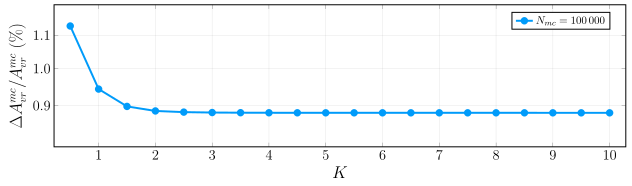

In [92]:
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc100K_Dl_10],
               label = [L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.80,1.2),
               yticks = [0.9, 1, 1.1],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.80, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_relative_errors.svg")


@show plot1

In [140]:
mu = 1.0

ampls_Dl = zeros(21,11)
errors_Dl = zeros(21,11) 

for Dl = 0:10

    ampls_Dl[1] = 0.0
    errors_Dl[1] = 0.0
    
    amplitude_Nmc100K_Dl, error_Nmc100K_Dl = get_VR_amplitudes(Dl,mu)

    ampls_Dl[2:end,Dl+1] .= 10^(17) .* amplitude_Nmc100K_Dl[:]
    errors_Dl[2:end, Dl+1] .= 10^(17) .* error_Nmc100K_Dl[:]
    
end

In [141]:
ampls_Dl

21×11 Matrix{Float64}:
 0.0        0.0        0.0       0.0       …  0.0       0.0       0.0
 0.0182982  0.0898426  0.165908  0.221638     0.329388  0.33713   0.343149
 0.0271992  0.14365    0.278416  0.383558     0.604336  0.621306  0.634635
 0.0278943  0.149197   0.292276  0.405919     0.651866  0.671325  0.686685
 0.0279696  0.149933   0.294393  0.409683     0.66178   0.681959  0.697925
 0.027981   0.150062   0.294807  0.410481  …  0.664332  0.684748  0.700919
 0.0279833  0.150091   0.294905  0.410685     0.66511   0.685614  0.701863
 0.0279839  0.150099   0.294937  0.410753     0.665408  0.685951  0.702235
 0.027984   0.150101   0.294946  0.410775     0.665517  0.686076  0.702375
 0.0279841  0.150102   0.29495   0.410784     0.665569  0.686137  0.702444
 0.0279841  0.150103   0.294952  0.410788  …  0.665592  0.686165  0.702476
 0.0279841  0.150103   0.294952  0.410789     0.665604  0.686178  0.702491
 0.0279841  0.150103   0.294953  0.41079      0.665608  0.686184  0.702498
 0.0279

plot1 = Plot{Plots.PGFPlotsXBackend() n=11}


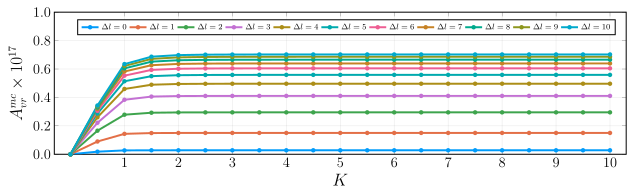

In [142]:
plot1 = plot(0:0.5:10,
    [ampls_Dl[:, 1], ampls_Dl[:, 2], ampls_Dl[:, 3], ampls_Dl[:, 4], ampls_Dl[:, 5], 
     ampls_Dl[:, 6], ampls_Dl[:, 7], ampls_Dl[:, 8], ampls_Dl[:, 9], ampls_Dl[:, 10], ampls_Dl[:, 11]],
               label = [L"\Delta l=0" L"\Delta l=1" L"\Delta l=2" L"\Delta l=3" L"\Delta l=4" L"\Delta l=5" L"\Delta l=6" L"\Delta l=7" L"\Delta l=8" L"\Delta l=9" L"\Delta l=10"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.0,1),
               #yticks = [0, 0.4, 0.8],
               ylabel = L"A_{vr}^{mc} \times 10^{17}",
               xlabel = L"K",
               #yerror = [errors_Dl[:, 1], errors_Dl[:, 2], errors_Dl[:, 3], errors_Dl[:, 4], errors_Dl[:, 5], 
               #          errors_Dl[:, 6], errors_Dl[:, 7], errors_Dl[:, 8], errors_Dl[:, 9], errors_Dl[:, 10], errors_Dl[:, 11]],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 3,
               legend_column = -1,
               legend = (0.04, 0.95),
               legendfontsize=8,
               yguidefontsize=16,
               xguidefontsize=16,
               )
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_increasing_Dl_$(mu).svg")


@show plot1

# Extrapolation

We now deal with the extrapolation. We use the _numerically stable_ version:

$$
W_{\Delta l} (K) = W(K, \Delta l) - \frac{(W(K, \Delta l) - W(K, \Delta l-1))^2}{W(K, \Delta l) - 2W(K, \Delta l-1) + W(K, \Delta l-2)}
$$

In [143]:
function extrapolate(dataDl, dataDlm1, dataDlm2)
    dataDl - (dataDl - dataDlm1)^2/(dataDl - 2*dataDlm1 + dataDlm2);
end

extrapolate (generic function with 1 method)

Let's extrapolate each trial *independently*. For each trial we sum all layers and then we extrapolate. 

We repeat this for all trials, averaging the final results.

In [35]:
test_ampl_DL10_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL10_Nmc100K[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] for id in 2:21]
end

test_ampl_DL9_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL9_Nmc100K[!,"$(trial)"]=[get_data(100000,9, trial).amp[id] for id in 2:21]
end

test_ampl_DL8_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL8_Nmc100K[!,"$(trial)"]=[get_data(100000,8, trial).amp[id] for id in 2:21]
end

test_ampl_extrapolation_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_extrapolation_Nmc100K[!,"$(trial)"]= extrapolate.(test_ampl_DL10_Nmc100K[!,"$(trial)"],test_ampl_DL9_Nmc100K[!,"$(trial)"],test_ampl_DL8_Nmc100K[!,"$(trial)"])
end

avg_ampl_extrapolation_Nmc100K =  [mean(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)]
var_ampl_extrapolation_Nmc100K =  [var(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)];

error_Nmc100K_extrap = sqrt.([var_ampl_extrapolation_Nmc100K[id] for id in 1:20]);

relative_error_Nmc100K_extrap = error_Nmc100K_extrap./avg_ampl_extrapolation_Nmc100K;

plot1 = Plot{Plots.PGFPlotsXBackend() n=1}


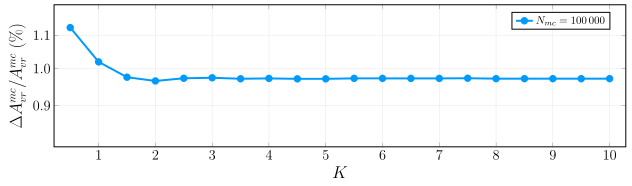

In [36]:
pgfplotsx()
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc100K_extrap],
               label = [L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.80,1.2),
               yticks = [0.9, 1, 1.1],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.80, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_extrapolations_relative_errors.svg")

@show plot1

Check that the sequence $A_{vr}(K,\Delta l)$ is linearly convergent. We compute the ratios $\lambda_K(\Delta l)$ and infer that the limit $\Delta l \to \infty$ is finite and smaller than 1.

In [22]:
function make_lambda(data)
    (data[3:end] .- data[2:end-1]) ./ (data[2:end-1] .- data[1:end-2])
end

make_lambda (generic function with 1 method)

In [23]:
data_10_shell = zeros(20, 11);

In [24]:
for Dl_index = 1:11

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000,Dl_index-1, trial).amp[id] - get_data(100000,Dl_index-1, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
    
data_10_shell[:, Dl_index] .= amplitude_Nmc100K[:]
    
end

In [26]:
lambda20 = make_lambda(data_10_shell[20,:]);
lambda15 = make_lambda(data_10_shell[15,:]);
lambda10 = make_lambda(data_10_shell[10,:]);

plotib0 = Plot{Plots.PGFPlotsXBackend() n=3}


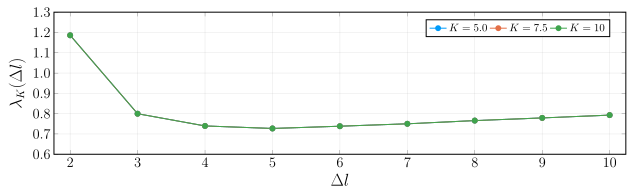

In [27]:
plotib0 = plot(
    2:10,
    [   
        lambda10,
        lambda15,
        lambda20,
    ],
    label = [ L"K=5.0" L"K=7.5" L"K=10"],
    xlabel = L"\Delta l",
    ylabel = L"\lambda_K(\Delta l)",
    markershape = [:circle :circle :circle],
    shape = [:circle :circle :circle],
    xticks = 2:10,
    ylim = (0.6, 1.3),
    size = (900, 300),
    legend = (0.65, 0.95),
    legend_column = -1,
    legendfontsize=11,
    yguidefontsize=16,
    xguidefontsize=16,
)

savefig(plotib0,"./plots/EPRL/vertex_renormalization/VR_lambda_K.svg")

@show plotib0